In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
import sys
import tensorflow as tf

# Projektets rot i Google Drive
PROJECT_DIR = "/content/drive/MyDrive/sepsis-timeline-project"
SRC_DIR = f"{PROJECT_DIR}/src"

# Byt arbetskatalog till projektroten
os.chdir(PROJECT_DIR)

# Lägg src/ i PYTHONPATH (stabilast i Colab)
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

# Sanity checks
print("✅ Current working directory:", os.getcwd())
print("✅ src/ in sys.path:", SRC_DIR in sys.path)
print("✅ TensorFlow version:", tf.__version__)
print("✅ GPU available:", tf.config.list_physical_devices("GPU"))


Mounted at /content/drive
✅ Current working directory: /content/drive/MyDrive/sepsis-timeline-project
✅ src/ in sys.path: True
✅ TensorFlow version: 2.19.0
✅ GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 03 — LSTM-modeller för sepsisprediktion

I denna notebook undersöks rekurrenta LSTM-modeller för tidig prediktion av sepsis
baserat på patienttidsserier från intensivvården.

Notebooken är uppdelad i två huvudsakliga delar:

---

## Del 1: LSTM-baseline

I den första delen implementeras en enkel LSTM-baseline:
- ett enda LSTM-lager
- ett litet tätt klassificeringshuvud
- standardinställningar för inlärningshastighet och dropout

Syftet med baselinemodellen är att etablera en rimlig referensnivå för
prestanda, samt att verifiera att preprocessing-pipelinen och
träningsproceduren fungerar korrekt.

---

## Del 2: Förbättrad LSTM-modell

I den andra delen vidareutvecklas baselinen genom en mer avancerad arkitektur:
- flera LSTM-lager (djupare modell)
- bättre regularisering (dropout och batch normalization)
- pooling över tid istället för att endast använda sista tidssteget
- utvärdering med fokus på PR-AUC, vilket är särskilt relevant vid klassobalans

Syftet är att undersöka om en mer uttrycksfull LSTM-modell kan förbättra
generaliseringsförmågan jämfört med baselinen, under i övrigt identiska
förutsättningar.

---

Alla experiment i denna notebook använder:
- samma preprocessade data (train/val/test)
- samma fönsterlängd \(T\) och prediktionshorisont \(H\)
- samma utvärderingsmått

Detta möjliggör en rättvis jämförelse mellan olika LSTM-arkitekturer.


In [2]:
# ============================================================
# Cell 3 — Imports
# ============================================================

import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)

print("✅ Imports klara")


✅ Imports klara


In [3]:
# ============================================================
# Cell 4 — Paths + meta (dev5000)
# ============================================================

DATA_DIR = f"{PROJECT_DIR}/data/processed/dev5000"   # <-- VIKTIGT: dev5000 här
FIG_DIR  = f"{PROJECT_DIR}/outputs/figures"
CKPT_DIR = f"{PROJECT_DIR}/outputs/checkpoints"

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

meta_path = os.path.join(DATA_DIR, "meta.json")
with open(meta_path, "r") as f:
    meta = json.load(f)

print("✅ DATA_DIR:", DATA_DIR)
print("✅ meta:", {k: meta[k] for k in ["N_PATIENTS","T","H","n_features_raw","n_features_model"] if k in meta})


✅ DATA_DIR: /content/drive/MyDrive/sepsis-timeline-project/data/processed/dev5000
✅ meta: {'N_PATIENTS': 5000, 'T': 48, 'H': 6, 'n_features_raw': 40, 'n_features_model': 80}


In [4]:
# ============================================================
# Cell 5 — Ladda train/val/test tensors
# ============================================================

train_X = np.load(os.path.join(DATA_DIR, "train_X.npy"))
train_y = np.load(os.path.join(DATA_DIR, "train_y.npy"))

val_X   = np.load(os.path.join(DATA_DIR, "val_X.npy"))
val_y   = np.load(os.path.join(DATA_DIR, "val_y.npy"))

test_X  = np.load(os.path.join(DATA_DIR, "test_X.npy"))
test_y  = np.load(os.path.join(DATA_DIR, "test_y.npy"))

print("TRAIN:", train_X.shape, train_y.shape, "| pos_rate:", float(train_y.mean()))
print("VAL  :", val_X.shape,   val_y.shape,   "| pos_rate:", float(val_y.mean()))
print("TEST :", test_X.shape,  test_y.shape,  "| pos_rate:", float(test_y.mean()))

print("NaN i TRAIN?", np.isnan(train_X).any())
print("NaN i VAL?",   np.isnan(val_X).any())
print("NaN i TEST?",  np.isnan(test_X).any())


TRAIN: (12825, 48, 80) (12825,) | pos_rate: 0.1352046783625731
VAL  : (2893, 48, 80) (2893,) | pos_rate: 0.11959903214656066
TEST : (2878, 48, 80) (2878,) | pos_rate: 0.1296038915913829
NaN i TRAIN? False
NaN i VAL? False
NaN i TEST? False


In [5]:
# ============================================================
# Cell 6 — tf.data pipelines (snabbare träning)
# ============================================================

BATCH_SIZE = 128

train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_ds = train_ds.shuffle(20_000, seed=42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_y))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ tf.data pipelines klara")


✅ tf.data pipelines klara


In [6]:
# Class weights (viktigt för obalanserad sepsis)
# Sepsis is rare, so I use class weights to penalize false negatives more.
# A simple weight rule: weight_1 ≈ (neg/pos)
# ============================================================
# Cell 7 — Class weights (viktigt pga obalans)
# ============================================================

neg = int((train_y == 0).sum())
pos = int((train_y == 1).sum())

w0 = 1.0
w1 = neg / max(pos, 1)

class_weight = {0: w0, 1: float(w1)}

print("Neg:", neg, "Pos:", pos)
print("✅ class_weight:", class_weight)


Neg: 11091 Pos: 1734
✅ class_weight: {0: 1.0, 1: 6.396193771626297}


In [7]:
# ============================================================
# Cell 8 — LSTM baseline (enkel startmodell)
# ============================================================

SEQ_LEN = train_X.shape[1]
NUM_FEATURES = train_X.shape[2]

def build_lstm_baseline(seq_len, num_features, hidden_units=128, dropout=0.2):
    inputs = keras.Input(shape=(seq_len, num_features), name="timeseries")

    # En LSTM som läser hela sekvensen och sammanfattar i ett hidden state
    x = layers.LSTM(hidden_units, dropout=dropout, recurrent_dropout=0.0, name="lstm")(inputs)

    # Litet dense-head
    x = layers.Dense(64, activation="relu", name="dense_1")(x)
    x = layers.Dropout(dropout, name="dropout_1")(x)

    outputs = layers.Dense(1, activation="sigmoid", name="p_sepsis")(x)

    model = keras.Model(inputs, outputs, name="lstm_baseline_dev5000")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.AUC(name="pr_auc", curve="PR"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model

baseline_model = build_lstm_baseline(SEQ_LEN, NUM_FEATURES)
baseline_model.summary()


Model: "lstm_baseline_dev5000"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ timeseries (InputLayer)         │ (None, 48, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       107,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_sepsis (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,329 (450.50 KB)

 Trainable params: 115,329 (450.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ============================================================
# Cell 9 — Callbacks (baseline) - vi monitorar val_pr_auc
# ============================================================

baseline_ckpt = os.path.join(CKPT_DIR, "best_lstm_baseline_dev5000.keras")

baseline_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_pr_auc", mode="max",
        patience=6, restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        baseline_ckpt, monitor="val_pr_auc", mode="max",
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_pr_auc", mode="max",
        factor=0.5, patience=2, min_lr=1e-5
    ),
]

print("✅ Baseline callbacks klara ->", baseline_ckpt)


✅ Baseline callbacks klara -> /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_lstm_baseline_dev5000.keras


In [9]:
# ============================================================
# Cell 10 — Träna baseline
# ============================================================

EPOCHS = 30

history_baseline = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=baseline_callbacks,
    verbose=1
)


Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - auc: 0.6330 - loss: 1.1173 - pr_auc: 0.2098 - precision: 0.1829 - recall: 0.5210 - val_auc: 0.6397 - val_loss: 0.7230 - val_pr_auc: 0.1587 - val_precision: 0.1678 - val_recall: 0.6936 - learning_rate: 0.0010
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8275 - loss: 0.8828 - pr_auc: 0.4339 - precision: 0.2931 - recall: 0.7861 - val_auc: 0.6635 - val_loss: 0.6047 - val_pr_auc: 0.2136 - val_precision: 0.2063 - val_recall: 0.5116 - learning_rate: 0.0010
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8966 - loss: 0.6985 - pr_auc: 0.5978 - precision: 0.3958 - recall: 0.8475 - val_auc: 0.6549 - val_loss: 0.6332 - val_pr_auc: 0.1880 - val_precision: 0.2137 - val_recall: 0.5405 - learning_rate: 0.0010
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9278 - loss: 0.5932 - pr_auc: 0.6673 - precision: 0.4595 - recall: 0.8840 - val_auc: 0.6308 - val_loss: 1.0074 - val_pr_auc: 0.1684 - val_precision: 0.1

In [10]:
# ============================================================
# Cell 11 — Improved LSTM (stacked + BN + pooling)
# ============================================================

def build_lstm_improved(seq_len, num_features, dropout=0.25):
    inputs = keras.Input(shape=(seq_len, num_features), name="timeseries")

    # Masking: om vissa timsteg är padding=0.0 kan modellen ignorera dem
    x = layers.Masking(mask_value=0.0, name="masking")(inputs)

    # Stacked LSTM: första behåller tidsdimensionen
    x = layers.LSTM(128, return_sequences=True, dropout=dropout, name="lstm_1")(x)
    x = layers.BatchNormalization(name="bn_1")(x)

    x = layers.LSTM(64, return_sequences=True, dropout=dropout, name="lstm_2")(x)
    x = layers.BatchNormalization(name="bn_2")(x)

    # Pooling över hela sekvensen (samlar info på två sätt)
    x_max = layers.GlobalMaxPooling1D(name="gmp")(x)
    x_avg = layers.GlobalAveragePooling1D(name="gap")(x)
    x = layers.Concatenate(name="concat_pool")([x_max, x_avg])

    # Dense-head
    x = layers.Dense(128, activation="relu", name="dense_1")(x)
    x = layers.Dropout(dropout, name="dropout_1")(x)

    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    x = layers.Dropout(dropout, name="dropout_2")(x)

    outputs = layers.Dense(1, activation="sigmoid", name="p_sepsis")(x)

    model = keras.Model(inputs, outputs, name="lstm_improved_dev5000")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.AUC(name="pr_auc", curve="PR"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model

improved_model = build_lstm_improved(SEQ_LEN, NUM_FEATURES, dropout=0.25)
improved_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'gmp' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "lstm_improved_dev5000"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timeseries          │ (None, 48, 80)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 48, 80)    │          0 │ timeseries[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 48, 80)    │          0 │ timeseries[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 48)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 48, 128)   │    107,008 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 48, 128)   │        512 │ lstm_1[0][0],     │
│ (BatchNormalizatio… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 48, 64)    │     49,408 │ bn_1[0][0],       │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 48, 64)    │        256 │ lstm_2[0][0],     │
│ (BatchNormalizatio… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmp                 │ (None, 64)        │          0 │ bn_2[0][0]        │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 64)        │          0 │ bn_2[0][0],       │
│ (GlobalAveragePool… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_pool         │ (None, 128)       │          0 │ gmp[0][0],        │
│ (Concatenate)       │                   │            │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ concat_pool[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_sepsis (Dense)    │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 182,017 (711.00 KB)

 Trainable params: 181,633 (709.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
# ============================================================
# Cell 14 — Hjälpfunktioner för att utvärdera och plotta
# ============================================================

def predict_proba(model, ds):
    """Returnerar sannolikheter (float) och true labels från tf.data.Dataset."""
    y_true = []
    y_prob = []
    for Xb, yb in ds:
        pb = model.predict(Xb, verbose=0).ravel()
        y_prob.append(pb)
        y_true.append(yb.numpy().ravel())
    return np.concatenate(y_true), np.concatenate(y_prob)

def savefig(path):
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("✅ Sparad:", path)


In [12]:
# ============================================================
# Cell 12 — Callbacks (improved) - monitor val_pr_auc
# ============================================================

improved_ckpt = os.path.join(CKPT_DIR, "best_lstm_improved_dev5000.keras")

improved_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_pr_auc", mode="max",
        patience=6, restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        improved_ckpt, monitor="val_pr_auc", mode="max",
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_pr_auc", mode="max",
        factor=0.5, patience=2, min_lr=1e-5
    ),
]

print("✅ Improved callbacks klara ->", improved_ckpt)


✅ Improved callbacks klara -> /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_lstm_improved_dev5000.keras


In [13]:
# ============================================================
# Cell 13 — Träna Improved LSTM
# ============================================================

EPOCHS = 30

history_improved = improved_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=improved_callbacks,
    verbose=1
)


Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - auc: 0.5530 - loss: 1.2379 - pr_auc: 0.1618 - precision: 0.1535 - recall: 0.4957 - val_auc: 0.6168 - val_loss: 0.6552 - val_pr_auc: 0.1907 - val_precision: 0.1799 - val_recall: 0.4595 - learning_rate: 0.0010
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - auc: 0.7288 - loss: 1.0527 - pr_auc: 0.2947 - precision: 0.2448 - recall: 0.6779 - val_auc: 0.6227 - val_loss: 0.6072 - val_pr_auc: 0.2391 - val_precision: 0.1602 - val_recall: 0.5231 - learning_rate: 0.0010
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8022 - loss: 0.9160 - pr_auc: 0.3463 - precision: 0.2727 - recall: 0.7626 - val_auc: 0.5878 - val_loss: 0.7520 - val_pr_auc: 0.1955 - val_precision: 0.1289 - val_recall: 0.6387 - learning_rate: 0.0010
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - auc: 0.8301 - loss: 0.8796 - pr_auc: 0.4206 - precision: 0.3077 - recall: 0.8158 - val_auc: 0.5630 - val_loss: 0.6237 - val_pr_auc: 0.1884 - val_precision: 

In [14]:
# ============================================================
# Cell 14 — Hjälpfunktioner för att utvärdera och plotta
# ============================================================

def predict_proba(model, ds):
    """Returnerar sannolikheter (float) och true labels från tf.data.Dataset."""
    y_true = []
    y_prob = []
    for Xb, yb in ds:
        pb = model.predict(Xb, verbose=0).ravel()
        y_prob.append(pb)
        y_true.append(yb.numpy().ravel())
    return np.concatenate(y_true), np.concatenate(y_prob)

def savefig(path):
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("✅ Sparad:", path)


✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_learning_loss.png


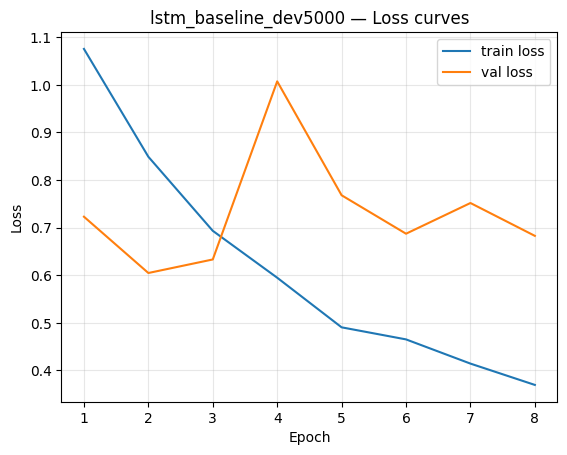

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_learning_auc.png


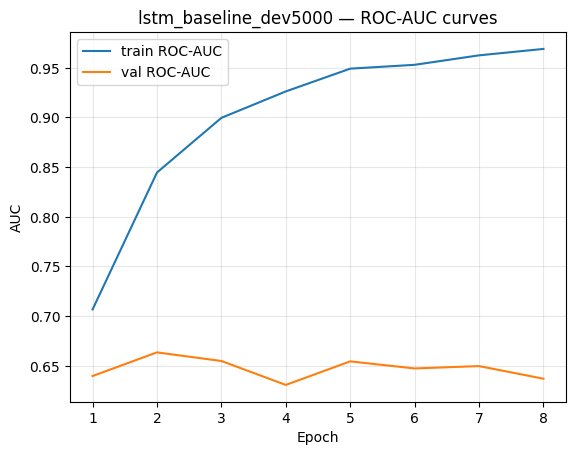

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_learning_pr_auc.png


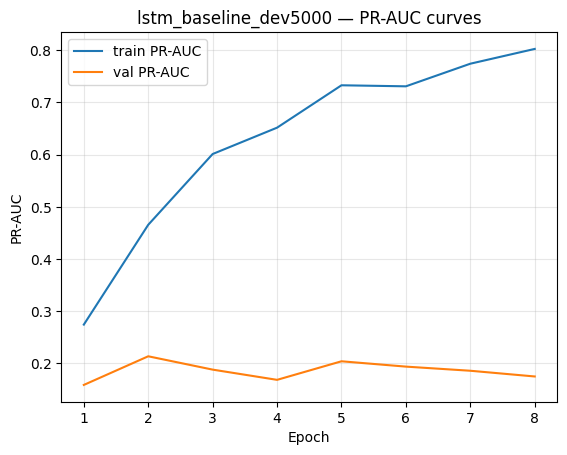

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_learning_loss.png


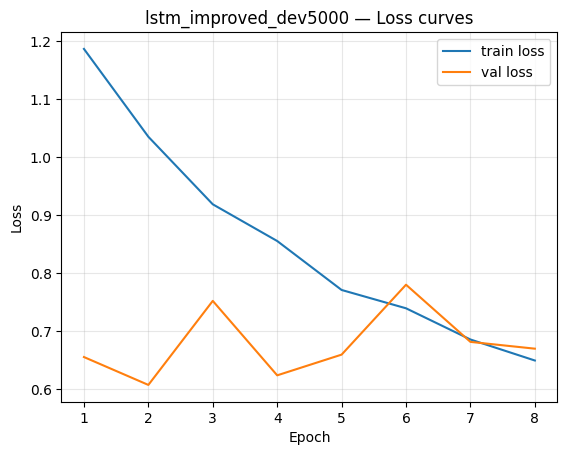

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_learning_auc.png


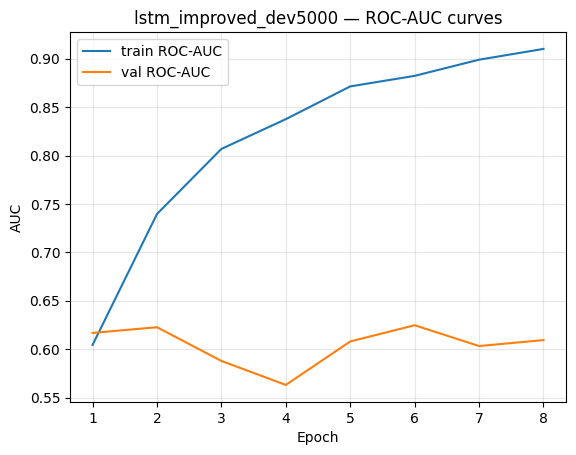

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_learning_pr_auc.png


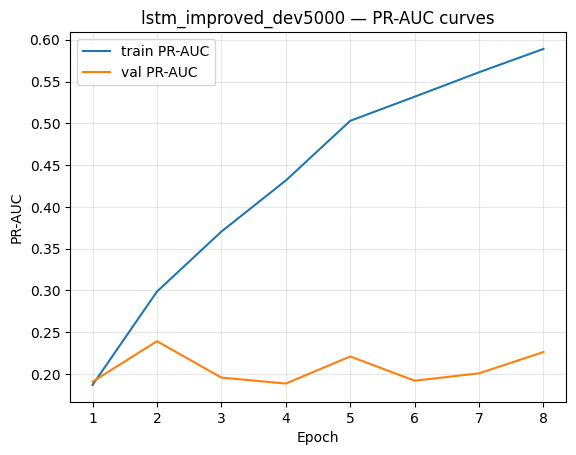

In [15]:
# ============================================================
# Cell 15 — Learning curves (loss + AUC) för båda modellerna
# ============================================================

def plot_learning_curves(history, prefix):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    # Loss
    plt.figure()
    plt.plot(epochs, hist["loss"], label="train loss")
    plt.plot(epochs, hist["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{prefix} — Loss curves")
    plt.legend()
    plt.grid(True, alpha=0.3)
    out = os.path.join(FIG_DIR, f"{prefix}_learning_loss.png")
    savefig(out)
    plt.show()

    # ROC-AUC (om finns)
    if "auc" in hist:
        plt.figure()
        plt.plot(epochs, hist["auc"], label="train ROC-AUC")
        plt.plot(epochs, hist["val_auc"], label="val ROC-AUC")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.title(f"{prefix} — ROC-AUC curves")
        plt.legend()
        plt.grid(True, alpha=0.3)
        out = os.path.join(FIG_DIR, f"{prefix}_learning_auc.png")
        savefig(out)
        plt.show()

    # PR-AUC (viktig)
    if "pr_auc" in hist:
        plt.figure()
        plt.plot(epochs, hist["pr_auc"], label="train PR-AUC")
        plt.plot(epochs, hist["val_pr_auc"], label="val PR-AUC")
        plt.xlabel("Epoch")
        plt.ylabel("PR-AUC")
        plt.title(f"{prefix} — PR-AUC curves")
        plt.legend()
        plt.grid(True, alpha=0.3)
        out = os.path.join(FIG_DIR, f"{prefix}_learning_pr_auc.png")
        savefig(out)
        plt.show()

plot_learning_curves(history_baseline, "lstm_baseline_dev5000")
plot_learning_curves(history_improved, "lstm_improved_dev5000")


✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_roc_val.png


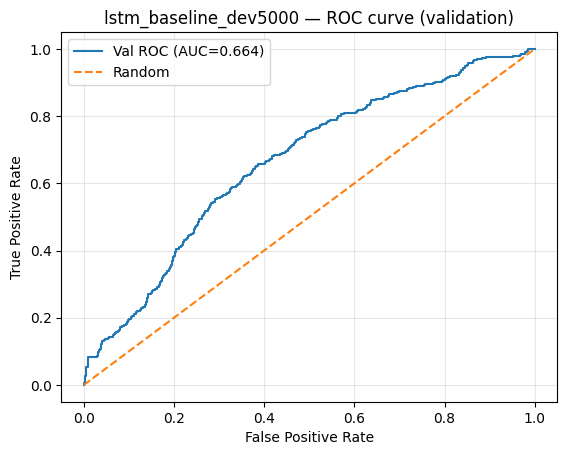

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_pr_val.png


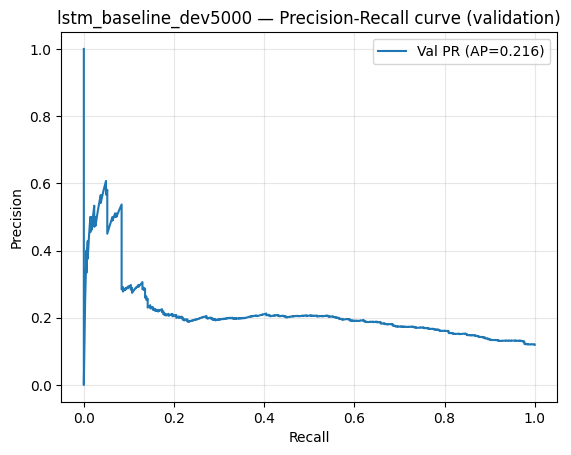

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_roc_test.png


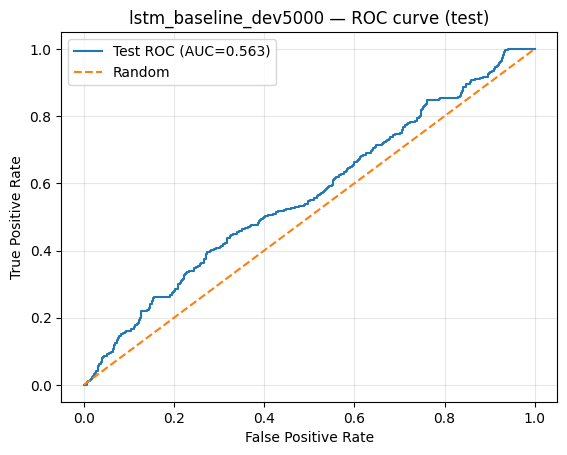

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_pr_test.png


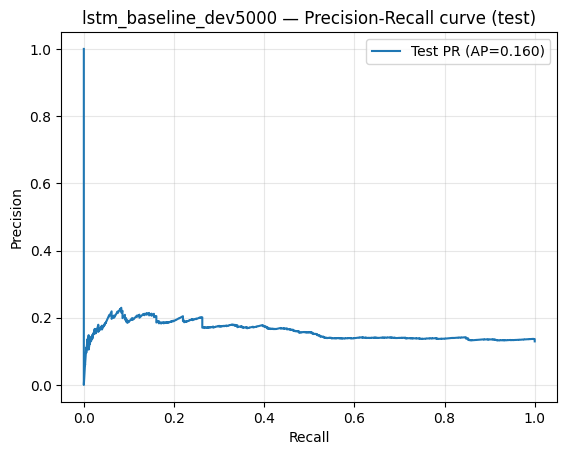

📌 lstm_baseline_dev5000 | VAL ROC-AUC=0.6637 | VAL PR-AUC=0.2159
📌 lstm_baseline_dev5000 | TEST ROC-AUC=0.5634 | TEST PR-AUC=0.1602


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'gmp' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_roc_val.png


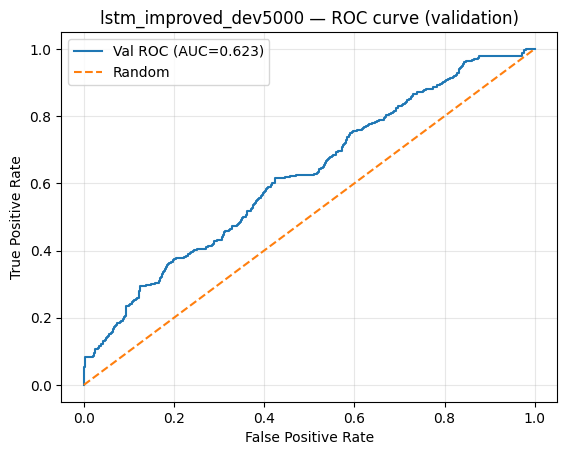

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_pr_val.png


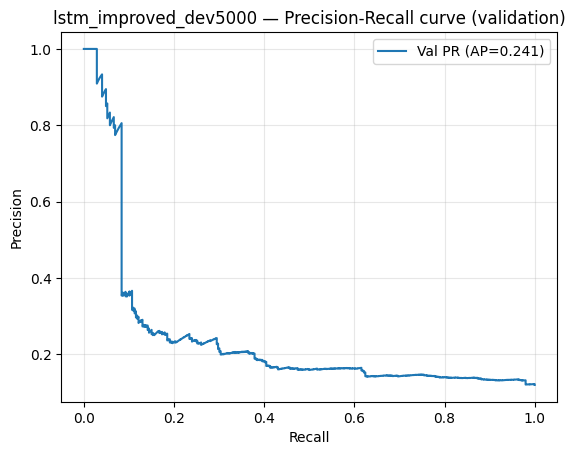

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_roc_test.png


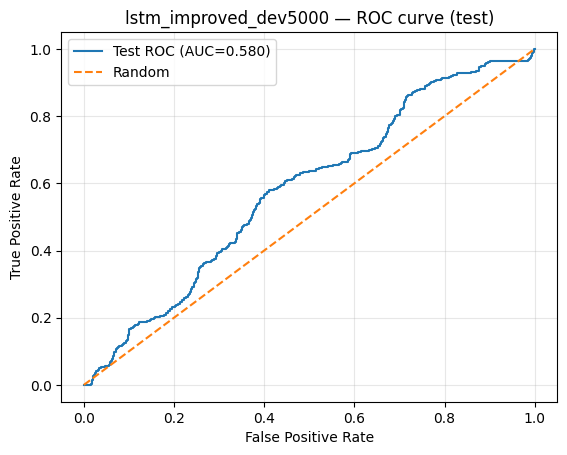

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_pr_test.png


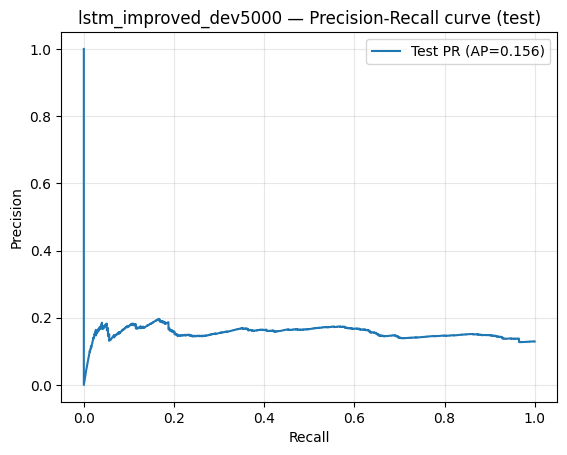

📌 lstm_improved_dev5000 | VAL ROC-AUC=0.6226 | VAL PR-AUC=0.2410
📌 lstm_improved_dev5000 | TEST ROC-AUC=0.5805 | TEST PR-AUC=0.1556


In [16]:
# ============================================================
# Cell 16 — ROC/PR curves (VAL + TEST)
# ============================================================

def plot_roc_pr(model, prefix):
    # --- VAL ---
    yv_true, yv_prob = predict_proba(model, val_ds)
    val_roc = roc_auc_score(yv_true, yv_prob)
    val_pr  = average_precision_score(yv_true, yv_prob)

    fpr, tpr, _ = roc_curve(yv_true, yv_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Val ROC (AUC={val_roc:.3f})")
    plt.plot([0,1],[0,1],"--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{prefix} — ROC curve (validation)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    out = os.path.join(FIG_DIR, f"{prefix}_roc_val.png")
    savefig(out)
    plt.show()

    prec, rec, _ = precision_recall_curve(yv_true, yv_prob)
    plt.figure()
    plt.plot(rec, prec, label=f"Val PR (AP={val_pr:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{prefix} — Precision-Recall curve (validation)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    out = os.path.join(FIG_DIR, f"{prefix}_pr_val.png")
    savefig(out)
    plt.show()

    # --- TEST ---
    yt_true, yt_prob = predict_proba(model, test_ds)
    test_roc = roc_auc_score(yt_true, yt_prob)
    test_pr  = average_precision_score(yt_true, yt_prob)

    fpr, tpr, _ = roc_curve(yt_true, yt_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Test ROC (AUC={test_roc:.3f})")
    plt.plot([0,1],[0,1],"--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{prefix} — ROC curve (test)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    out = os.path.join(FIG_DIR, f"{prefix}_roc_test.png")
    savefig(out)
    plt.show()

    prec, rec, _ = precision_recall_curve(yt_true, yt_prob)
    plt.figure()
    plt.plot(rec, prec, label=f"Test PR (AP={test_pr:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{prefix} — Precision-Recall curve (test)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    out = os.path.join(FIG_DIR, f"{prefix}_pr_test.png")
    savefig(out)
    plt.show()

    print(f"📌 {prefix} | VAL ROC-AUC={val_roc:.4f} | VAL PR-AUC={val_pr:.4f}")
    print(f"📌 {prefix} | TEST ROC-AUC={test_roc:.4f} | TEST PR-AUC={test_pr:.4f}")

plot_roc_pr(baseline_model, "lstm_baseline_dev5000")
plot_roc_pr(improved_model, "lstm_improved_dev5000")


Confusion matrix (TEST):
[[1532  973]
 [ 191  182]]

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.889     0.612     0.725      2505
           1      0.158     0.488     0.238       373

    accuracy                          0.596      2878
   macro avg      0.523     0.550     0.481      2878
weighted avg      0.794     0.596     0.662      2878

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_confusion_test_thr0.50.png


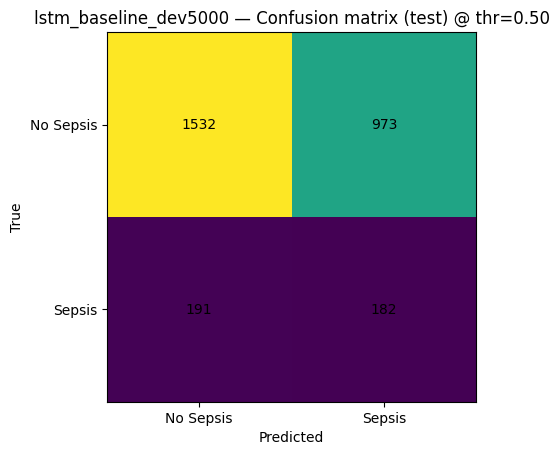

Confusion matrix (TEST):
[[1610  895]
 [ 196  177]]

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.891     0.643     0.747      2505
           1      0.165     0.475     0.245       373

    accuracy                          0.621      2878
   macro avg      0.528     0.559     0.496      2878
weighted avg      0.797     0.621     0.682      2878

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_confusion_test_thr0.50.png


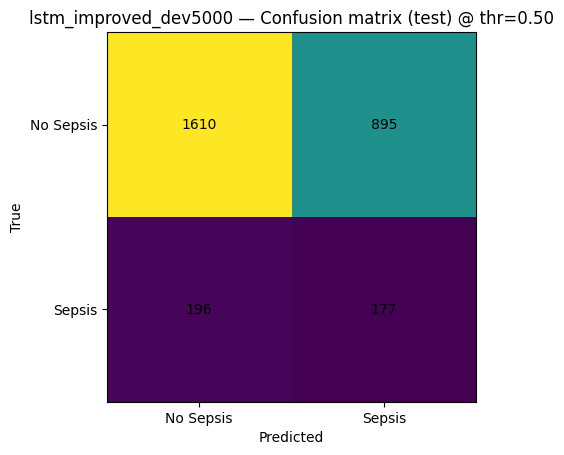

In [17]:
# ============================================================
# Cell 17 — Confusion matrix (TEST) med en enkel threshold
# ============================================================

def plot_confusion(model, prefix, threshold=0.5):
    yt_true, yt_prob = predict_proba(model, test_ds)
    yt_pred = (yt_prob >= threshold).astype(int)

    cm = confusion_matrix(yt_true, yt_pred)
    print("Confusion matrix (TEST):")
    print(cm)
    print("\nClassification report (TEST):")
    print(classification_report(yt_true, yt_pred, digits=3))

    plt.figure()
    plt.imshow(cm)
    plt.title(f"{prefix} — Confusion matrix (test) @ thr={threshold:.2f}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0,1], ["No Sepsis","Sepsis"])
    plt.yticks([0,1], ["No Sepsis","Sepsis"])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    out = os.path.join(FIG_DIR, f"{prefix}_confusion_test_thr{threshold:.2f}.png")
    savefig(out)
    plt.show()

plot_confusion(baseline_model, "lstm_baseline_dev5000", threshold=0.5)
plot_confusion(improved_model, "lstm_improved_dev5000", threshold=0.5)


In [18]:
# ============================================================
# Cell 18 — Sammanfattning (snabbt för rapporten)
# ============================================================

summary = {
    "dataset": DATA_DIR,
    "train_shape": list(train_X.shape),
    "val_shape": list(val_X.shape),
    "test_shape": list(test_X.shape),
    "class_weight": class_weight,
    "figures_expected": {
        "baseline": [
            "lstm_baseline_dev5000_learning_loss.png",
            "lstm_baseline_dev5000_learning_auc.png",
            "lstm_baseline_dev5000_learning_pr_auc.png",
            "lstm_baseline_dev5000_roc_val.png",
            "lstm_baseline_dev5000_pr_val.png",
            "lstm_baseline_dev5000_roc_test.png",
            "lstm_baseline_dev5000_pr_test.png",
            "lstm_baseline_dev5000_confusion_test_thr0.50.png",
        ],
        "improved": [
            "lstm_improved_dev5000_learning_loss.png",
            "lstm_improved_dev5000_learning_auc.png",
            "lstm_improved_dev5000_learning_pr_auc.png",
            "lstm_improved_dev5000_roc_val.png",
            "lstm_improved_dev5000_pr_val.png",
            "lstm_improved_dev5000_roc_test.png",
            "lstm_improved_dev5000_pr_test.png",
            "lstm_improved_dev5000_confusion_test_thr0.50.png",
        ],
    }
}

print("✅ Klar. Kort sammanfattning:")
for k, v in summary.items():
    print(k, ":", v)


✅ Klar. Kort sammanfattning:
dataset : /content/drive/MyDrive/sepsis-timeline-project/data/processed/dev5000
train_shape : [12825, 48, 80]
val_shape : [2893, 48, 80]
test_shape : [2878, 48, 80]
class_weight : {0: 1.0, 1: 6.396193771626297}
figures_expected : {'baseline': ['lstm_baseline_dev5000_learning_loss.png', 'lstm_baseline_dev5000_learning_auc.png', 'lstm_baseline_dev5000_learning_pr_auc.png', 'lstm_baseline_dev5000_roc_val.png', 'lstm_baseline_dev5000_pr_val.png', 'lstm_baseline_dev5000_roc_test.png', 'lstm_baseline_dev5000_pr_test.png', 'lstm_baseline_dev5000_confusion_test_thr0.50.png'], 'improved': ['lstm_improved_dev5000_learning_loss.png', 'lstm_improved_dev5000_learning_auc.png', 'lstm_improved_dev5000_learning_pr_auc.png', 'lstm_improved_dev5000_roc_val.png', 'lstm_improved_dev5000_pr_val.png', 'lstm_improved_dev5000_roc_test.png', 'lstm_improved_dev5000_pr_test.png', 'lstm_improved_dev5000_confusion_test_thr0.50.png']}
